# K-means实战——对地理位置进行聚类

K-means

优点：容易实现。

缺点：可能收敛到局部最小值，在大规模数据集上收敛慢。

适用数据类型：数值型数据。

**算法流程**

创建K个点作为起始质心（随机选择）
当任意一个点的簇分配结果发生改变时
    对数据集中的每个数据点
        对每个质心
            计算质心与数据点之间的距离
        将数据点分配到距其最近的簇
    对每个簇，计算簇中所有点的均值并将均值作为质心

**实现流程**

1. 收集数据
2. 准备数据：使用数值型数据来计算距离，也可将标称型数据映射为二值数据后再用于距离计算
3. 分析数据
4. 训练算法：不适用于无监督学习，即无监督学习没有训练过程
5. 测试算法：应用聚类算法，观察结果，可量化误差指标，如误差平方和进行评价
6. 使用算法：使用簇质心代表整个簇的数据做出决策

In [1]:
from numpy import *
def loadDataSet(fileName):
    dataMat = []
    with open(fileName) as fr:
        for line in fr.readlines():
            curLine = line.strip().split('\t')
            fltLine = list(map(float, curLine))
            dataMat.append(fltLine)
        return dataMat
def distEclud(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2)))

def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k, n)))
    #构建质心
    for j in range(n):
        minJ = min(dataSet[:,j])
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = minJ + rangeJ * random.rand(k,1)
    return centroids
dataMat = mat(loadDataSet('testSet.txt'))

In [2]:
min(dataMat[:,0])

matrix([[-5.379713]])

In [3]:
min(dataMat[:,1])

matrix([[-4.232586]])

In [4]:
max(dataMat[:,0])

matrix([[4.838138]])

In [5]:
max(dataMat[:,1])

matrix([[5.1904]])

In [6]:
randCent(dataMat, 2)

matrix([[-2.29935078,  0.18891977],
        [-4.20081364,  4.16545085]])

In [7]:
distEclud(dataMat[0], dataMat[1])

5.184632816681332

In [13]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m, 2))) #0保存属于哪个质心，1保存SSE
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        #更新每个样本所属质心和最短距离平方
        for i in range(m):
            minDist, minIndex = float('inf'), -1
            for j in range(k):
                curDist = distMeas(centroids[j,:], dataSet[i,:])
                if curDist < minDist:minDist, minIndex = curDist, j
            if clusterAssment[i, 0] != minIndex:clusterChanged=True
            clusterAssment[i,:] = minIndex, minDist**2
#         print(centroids)
        #更新质点
        for cent in range(k):
            curClust = dataSet[nonzero(clusterAssment[:,0].A == cent)[0]]
            centroids[cent,:] = mean(curClust, axis=0)
    return centroids, clusterAssment #返回质心和包含每个结点属于哪个质心的列表    
myCentroids, clustAssing = kMeans(dataMat, 4)

In [9]:
def biKmeans(dataSet, k, distMeas=distEclud):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))
    #1.创建一个初始簇
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    centList = [centroid0]
    for j in range(m):
        clusterAssment[:,1] = distMeas(mat(centroid0), dataSet[j,:]) ** 2
    while (len(centList) < k):
        lowestSSE = float('inf')
        #2.尝试划分每一簇
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:]
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:, 1])
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A != i)[0], 1])
#             print("sseSplit, and notSplit: ", sseSplit, sseNotSplit)
            if sseSplit + sseNotSplit < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        #3.更新簇的分配结果
        bestClustAss[nonzero(bestClustAss[:,0].A==1)[0], 0] = len(centList)
        bestClustAss[nonzero(bestClustAss[:,0].A==0)[0], 0] = bestCentToSplit
#         print('the bestCentToSplit is:', bestCentToSplit)
#         print('the len of bestClustAss is:', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0, :]
        centList.append(bestNewCents[1,:])
        clusterAssment[nonzero(clusterAssment[:,0].A==bestCentToSplit)[0],:]=bestClustAss
    return array(centList), clusterAssment

In [34]:
myCentroids, clustAssing = biKmeans(dataMat, 4)
myCentroids

array([[[-2.46154315,  2.78737555]],

       [[ 2.65077367, -2.79019029]],

       [[-3.53973889, -2.89384326]],

       [[ 2.6265299 ,  3.10868015]]])

## 示例：对地理数据应用二分K-Means算法

1. 收集数据：使用地图API获取数据
2. 准备数据：保留经纬度信息
3. 分析数据：用matplotlib构建二维数据图，包含簇和地图
4. 训练算法：不适用无监督学习
5. 测试算法：使用biKmeans()函数
6. 使用算法：输出包含簇及簇中心的地图


In [11]:
#球面距离计算
def distSLC(vecA, vecB):
    a = sin(vecA[0,1]*pi/180) * sin(vecB[0,1]*pi/180)
    b = cos(vecA[0,1]*pi/180) * cos(vecB[0,1]*pi/180) * cos(pi*(vecB[0,0]-vecA[0,0])/180)
    return arccos(a+b)*6371.0

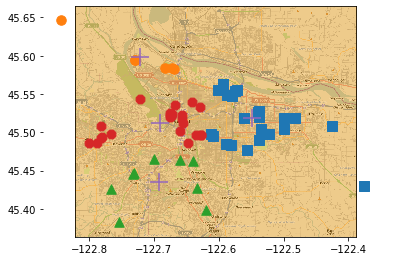

In [33]:
import matplotlib
import matplotlib.pyplot as plt
#在地图图片的基础上，画样本点和质心的散点图
def clusterClubs(numClust=5):
    datList = []
    for line in open('places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = mat(datList)
    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)
    fig = plt.figure()
    rect = [0.1, 0.1, 0.8, 0.8]
    scatterMarkers = ['s', 'o', '^', '8', 'p', 'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0 = fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('Portland.png')
    ax0.imshow(imgP)
    ax1 = fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[nonzero(clustAssing[:,0].A==i)[0],:]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0],
                    marker=markerStyle, s=90)
    myCentroids = squeeze(myCentroids)
    ax1.scatter(myCentroids[:,0].flatten(), myCentroids[:,1].flatten(),marker='+',s=300)
    plt.show()
clusterClubs(4)